In [1]:
import sys
sys.path.append("/Users/ratnadeepb/research/park")

In [2]:
import numpy as np
import random
# from IPython.display import clear_output
from collections import deque
import progressbar

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.optimizers import Adam
import park

In [3]:
# default floatx is float32
# to change individual layer type add `dtype=float64` to layer constructor
tf.keras.backend.set_floatx('float64') # change all layer default output to float64; default is float32

In [4]:
env = park.make("load_balance")
print('Number of states: {}'.format(env.observation_space.shape[0]))
print('Number of actions: {}'.format(env.action_space.n))

INFO:root:Making new env load_balance


Number of states: 11
Number of actions: 10


In [36]:
class Agent:
    def __init__(self, env, optimizer):
        
        # Initialize atributes
        self._state_size = env.observation_space.shape
#         self._state_size = env.observation_space.shape
        self._action_size = env.action_space.n
        self._optimizer = optimizer
        
        self.expirience_replay = deque(maxlen=2000)
        
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.1
        
        # Build networks
        self.q_network = self._build_compile_model()
        self.target_network = self._build_compile_model()
        self.align_target_model()

    def store(self, state, action, reward, next_state, terminated):
        # Store experience
        self.expirience_replay.append((state, action, reward, next_state, terminated))
    
    def _build_compile_model(self):
        # Create the model
        # a feedforward network
        model = Sequential()
        model.add(Input(env.observation_space.shape)) # prepare the data for the feedforward network
        model.add(Dense(30, activation='relu'))
#         model.add(Dense(50, activation='relu', input_shape=self._state_size))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self._action_size, activation='linear'))
        
        # Configure a model for mean-squared error regression.
        model.compile(loss='mse', optimizer=self._optimizer, metrics=['mae'])
        return model

    def align_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Explore
            return env.action_space.sample()
        # greedy action
        q_values = self.q_network.predict(state.reshape(1, 11))
        return np.argmax(q_values[0])

    def retrain(self, batch_size):
        # pick random samples from experience memory and train the network
        minibatch = random.sample(self.expirience_replay, batch_size)
        
        for state, action, reward, next_state, terminated in minibatch:
            
            target = self.q_network.predict(state.reshape(1, 11))
            
            if terminated:
                target[0][action] = reward
            else:
                t = self.target_network.predict(next_state.reshape(1, 11))
                target[0][action] = reward + self.gamma * np.amax(t)
            
            self.q_network.fit(state.reshape(1, 11), target, epochs=1, verbose=0)

In [45]:
optimizer = Adam(learning_rate=0.01)
agent = Agent(env, optimizer)

batch_size = 100
num_of_episodes = 5
timesteps_per_episode = 20
agent.q_network.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 30)                360       
_________________________________________________________________
dense_37 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_38 (Dense)             (None, 10)                310       
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [46]:
STATES = []
REWARDS = []
for e in range(num_of_episodes):
    # Reset the env
    state = env.reset()
    
    # Initialize variables
    reward = 0
    terminated = False
    
    bar = progressbar.ProgressBar(maxval=timesteps_per_episode/10, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(state)
        
        # Take action    
        # step() is a function provided by OpenAIGym to step through the environment
        # the step function provides if episode has terminated
        next_state, reward, terminated, info = env.step(action)
        REWARDS.append(reward)
        agent.store(state, action, reward, next_state, terminated)
        
        state = next_state
        
        STATES.append(state) # store all steps
        
        if terminated:
            agent.align_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)
        
        if timestep%10 == 0:
            bar.update(timestep/10 + 1)
    
    bar.finish()
    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
#         env.render()
        print("**********************************")

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


In [47]:
predictions = agent.target_network.predict(state.reshape(1, 11))
tf.nn.softmax(predictions).numpy(), tf.nn.softmax(predictions).numpy(), np.argmax(tf.nn.softmax(predictions).numpy())

(array([[6.26720386e-195, 2.34217286e-237, 3.71331708e-213,
         5.79759048e-315, 2.74089289e-089, 4.20123676e-007,
         9.99999580e-001, 2.38066992e-277, 6.39507848e-268,
         1.43913942e-284]]),
 array([[6.26720386e-195, 2.34217286e-237, 3.71331708e-213,
         5.79759048e-315, 2.74089289e-089, 4.20123676e-007,
         9.99999580e-001, 2.38066992e-277, 6.39507848e-268,
         1.43913942e-284]]),
 6)

In [48]:
np.mean(np.array(REWARDS)), np.std(np.array(REWARDS)), np.min(np.array(REWARDS)), reward

(-458.57, 641.2627270471909, -4751.0, -240.0)

In [10]:
STATES = np.array(STATES)

In [11]:
means = [STATES[:, i].mean() for i in range(STATES.shape[1] - 1)]

In [12]:
std = [STATES[:, i].std() for i in range(STATES.shape[1] - 1)]

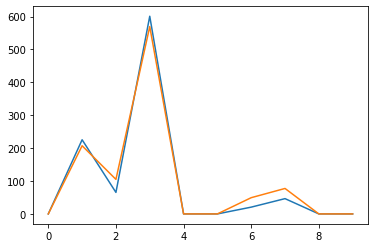

In [13]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(10)], means)
plt.plot([i for i in range(10)], std)

In [20]:
STATES

[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,  82.,   0.,   0., 259.]),
 array([  0.,   0.,   0.,   0., 433.,   0.,   0.,  45.,   0.,   0., 267.]),
 array([  0.,   0.,   0.,   0., 403.,   0., 326.,  15.,   0.,   0., 163.]),
 array([  0.,   0.,   0., 356., 397.,   0., 320.,   9.,   0.,   0., 101.]),
 array([  0.,   0.,   0., 402., 342.,   0., 265.,   0.,   0.,   0., 102.]),
 array([  0.,   0.,   0., 465., 303.,   0., 226.,   0.,   0.,   0., 128.]),
 array([  0.,   0.,   0., 578., 288.,   0., 211.,   0.,   0.,   0., 489.]),
 array([  0.,   0.,   0., 990., 211.,   0., 134.,   0.,   0.,   0., 142.]),
 array([   0.,    0.,    0., 1128.,  207.,    0.,  130.,    0.,    0.,
           0.,  118.]),
 array([   0.,    0.,    0., 1237.,  198.,    0.,  121.,    0.,    0.,
           0.,  125.]),
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0., 578.,   0.,   0., 195.]),
 array([  0.,   0., 546.,   0.,   0.,   0.,   0., 567.,   0.,   0., 296.]),
 array([   0., 1142.,  504.,    0.,    0.,    0., 